# BEC Simulation Notebook

This notebook provides an interactive environment for simulating 2D Bose-Einstein condensates dynamics.

In [47]:
# Import required modules
import numpy as np
import cupy as cp
import json
import os
import sys
from argparse import Namespace

# Add current directory to Python path
sys.path.insert(0, '.')

# Import project modules
import arguments as agms
import wf
import evolve as ev
import mechanical as mc
import draw
from constants import t0, hbar, m, x0, e0, a, ab

print("Modules imported successfully!")

Modules imported successfully!


## 1. 参数输入

设置模拟参数，这些参数通常在命令行中传递

In [48]:
# Simulation parameters with detailed comments
args = Namespace(
    # Atomic mass of the particle in amu (e.g. 87 means Rb-87)
    relative_atomic_mass=87, 
    # Scattering length in Bohr radius (e.g. 10 means a_s = 10 a_Bohr)
    scattering_length=0,
    # Number of atoms
    atom_number=2500, 
    # Total duration of simulation in ms
    duration=200, 
    # Time step in ms
    dt=0.5, 
    # After how many time steps to sample the wave function
    sampling_interval=10, 
    # Radius of the real space simulation region in μm (e.g. (50, 40) means -50 to 50 μm in x and -40 to 40 μm in y)
    radius_xy=(50, 50), 
    # Number of points in x and y directions (e.g. (256, 256) means 256 points in both x and y directions) (When N is a power of 2, the FFT is faster)
    number_xy=(256, 256),
    # Trapping frequency in ms^-1
    omega_trap=0.01*cp.pi, 
    # Center of the trap in μm (e.g. (0, 0) means the center is at (0, 0) μm)
    center_trap=(0, 0), 
    # Anharmonic parameter (dimensionless) (V = 0.5*m*omega^2*((1-2*beta)*(x^2+y^2) + (beta/r_0)*(x^2+y^2)^2)), where r_0 is the length scale to keep beta dimensionless)
    beta=-0.1, 
    # Trapping frequency along z in ms^-1
    omega_trap_z=0.005*cp.pi, 
    # Length scale to keep beta dimensionless (e.g. 1 means the length scale is 1 μm)
    r_0=30, 
    # Center of the BEC in μm (e.g. 25, 25 means the center is at (25, 25) μm, and r_0 will be set to sqrt(2)*25 μm)
    center_bec=(30, 0), 
    # The frequency of the harmonic trap whose ground state is this gaussian wavepacket
    omega_bec=0.01*cp.pi, 
    # The angular momentum eigenstate (l, m) (e.g. (2, 1) means l = 2, m = 1)
    angular_momentum_bec=(0, 0),
    # If set, perform imaginary time evolution
    imaginary_time=False, 
    # Velocity of the initial wavepacket in μm/ms (e.g. (0, 0) means no initial velocity)
    velocity=(0, 3*cp.pi/10),
    # If set, save the simulation process as a video
    video=False, 
    # If set, save the simulation results as a figure
    figure=True, 
    # If set, save the mechanical quantities during the simulation
    mechanics=True
)

# Display parameters
agms.display_args(args)

# Update the constants.json file with the new atomic parameters
with open("constants.json", "r") as f:
    constants = json.load(f)
constants["Ar"] = int(args.relative_atomic_mass)
constants["a"] = float(args.scattering_length)
with open("constants.json", "w") as f:
    json.dump(constants, f, indent=4, ensure_ascii=False)

parameters:

## Atomic parameters ##
relative atomic mass: 87 amu
scattering length: 0 a_Bohr
number of atoms: 2500

## time structure ##
duration: 200 ms
time step: 0.5 ms
sampling interval: 10

## grid structure ##
radius in x: 50 μm, radius in y: 50 μm
number in x: 256, number in y: 256

## potential trap ##
trapping frequency ω: 0.031415926535897934 ms^-1
center of the trap: (0, 0) μm
anharmonic parameter β: -0.1
length scale r_0: 30 μm
trapping frequency along z direction ω_z: 0.015707963267948967 ms^-1

## initial wavepacket ##
center of the BEC: (30, 0) μm
trapping frequency of BEC ω_BEC: 0.031415926535897934 ms^-1
initial velocity: (0, 0.9424777960769379) μm/ms
initial angular momentum eigenstate (l, m): (0, 0)

## overall simulation settings ##
imaginary time evolution: off
video record: off
mechanical quantities: on
figure output: on



## 2. 波函数和势能初始化

初始化波函数、势能和网格

In [49]:
# Time dimensionless
# args.omega_trap = args.omega_trap / t0
args.omega_bec = args.omega_bec / t0
args.omega_trap_z = args.omega_trap_z / t0

# interacting strength #
g = (4*cp.pi*args.atom_number * hbar**2 * a*ab / m / e0 / x0**3
     ) * cp.sqrt(m*args.omega_trap_z/2/cp.pi/hbar * x0
                 ) # correction for squeezing a 3D wavepacket (along z direction) into a x0 μm layer

# Generate the time structure
(duration, n_steps, n_samples) = ev.time_step(dt=args.dt, duration=args.duration, sampling_interval=args.sampling_interval)

# Generate the grid, operators, and initial wavefunction
(X, Y, Kx, Ky, dx, dy) = wf.grid(x_range=(-args.radius_xy[0], args.radius_xy[0]),
                                  y_range=(-args.radius_xy[1], args.radius_xy[1]),
                                    Nx=args.number_xy[0], Ny=args.number_xy[1])

# Initialize potential operator (can be modified between evolution steps)
def update_potential(center=(0, 0), beta=-0.1, omega=None):
    global U, V_sqrt, T, args
    # Use provided omega or default to current args.omega_trap
    omega_dimless = omega if omega is not None else args.omega_trap
    # wf.operator may return more than three values in some versions.
    # Accept any extras and only assign the first three expected operators.
    U, V_sqrt, T = wf.operator(X=X, Y=Y, Kx=Kx, Ky=Ky, omega=omega_dimless,
                                      trap_center=np.array(center), beta=beta, 
                                      r_0=args.r_0, imaginary_time=args.imaginary_time, dt=args.dt)

# Initialize with default potential
update_potential(center=args.center_trap, beta=args.beta, omega=args.omega_trap)

# Initialize wavefunction
psi = wf.wf_Gaussian(X=X, Y=Y, BEC_center=np.array(args.center_bec), omega=args.omega_bec, 
                     l=args.angular_momentum_bec[0], lz=args.angular_momentum_bec[1], dx=dx, dy=dy)
psi = wf.boost(psi=psi, X=X, Y=Y, vx=args.velocity[0], vy=args.velocity[1])


print("Wavefunction and potential initialized successfully!")
print(f"Grid size: {X.shape}")
print(f"Time step dt: {args.dt:.3f} ms, Total steps: {n_steps}")

Wavefunction and potential initialized successfully!
Grid size: (256, 256)
Time step dt: 0.500 ms, Total steps: 400


## 3. 输出初始化

检查输出目录并初始化用于存储力学量的数组

In [50]:
# Check and create output directory if it doesn't exist
if not os.path.exists('output'):
    os.makedirs('output')
    print("Created output directory")
else:
    print("Output directory already exists")

# Initialize output arrays for mechanical quantities
n_steps = n_steps + 1 # include the last step
time = 0 # ms
idx_sampling = 0 # index for sampling
time_list = cp.zeros(n_samples, dtype=cp.float32)
Iz_tot_list = cp.zeros(n_samples, dtype=cp.float32)
Iz_sr_list = cp.zeros(n_samples, dtype=cp.float32)
Lz_tot_list = cp.zeros(n_samples, dtype=cp.float32)
Lz_sr_list = cp.zeros(n_samples, dtype=cp.float32)
omega_tot_list = cp.zeros(n_samples, dtype=cp.float32)
omega_sr_list = cp.zeros(n_samples, dtype=cp.float32)
ang_c_list = cp.zeros(n_samples, dtype=cp.float32)
ang_l_list = cp.zeros(n_samples, dtype=cp.float32)
ang_s_list = cp.zeros(n_samples, dtype=cp.float32)

print("Output arrays initialized successfully!")

Output directory already exists
Output arrays initialized successfully!


## 4. 时间演化循环

实现波函数的时间演化，支持多次运行和参数修改

In [51]:
# Function to perform time evolution
def evolve(duration_ms=50, new_trap_center=None, new_beta=None, new_trap_omega=None, save_figure=True, save_video=False):
    global psi, time, idx_sampling, g, dt
    
    # Convert physical time to number of steps
    steps = int(cp.round(duration_ms / args.dt))
    print(f"Evolution for {duration_ms} ms = {steps} steps")
    
    # Update potential if new parameters are provided
    center = new_trap_center if new_trap_center is not None else args.center_trap
    beta = new_beta if new_beta is not None else args.beta
    omega = new_trap_omega / t0 if new_trap_omega is not None else args.omega_trap
    # Update the global args for consistency
    args.center_trap = center if new_trap_center is not None else args.center_trap
    args.beta = new_beta if new_beta is not None else args.beta
    args.omega_trap = new_trap_omega / t0 if new_trap_omega is not None else args.omega_trap

    update_potential(center=center, beta=beta, omega=omega)
    print(f"Potential updated with center={center}, beta={beta}, omega={new_trap_omega if new_trap_omega is not None else args.omega_trap*t0:.4f} ms^-1")
    
    # Video output setup (simplified version)
    if save_video:
        print("Warning: Video output not fully implemented in notebook version")
    
    # Perform time evolution
    for step in range(steps):
        # Sample mechanical quantities if needed
        if args.mechanics and step % (args.sampling_interval) == 0:
            # Mechanical quantities
            psi1 = mc.wo_COM(psi=psi, X=X, Y=Y, Kx=Kx, Ky=Ky, dx=dx, dy=dy)
            Iz_tot = mc.Iz(psi=psi, X=X, Y=Y, dx=dx, dy=dy, Num=args.atom_number)
            Iz_sr = mc.Iz_c(psi=psi, X=X, Y=Y, dx=dx, dy=dy, Num=args.atom_number)
            (Fx,Fy,Fx1,Fy1) = mc.flow_field(psi=psi, psi1 = psi1, Kx=Kx, Ky=Ky)
            (Lz_tot, Lz_sr, omega_tot, omega_sr) = mc.rotate(Fx=Fx, Fy=Fy, Fx1=Fx1, Fy1=Fy1, dx=dx, dy=dy, X=X, Y=Y, Num=args.atom_number, Iz_tot=Iz_tot, Iz_sr=Iz_sr)
            (ang_c, ang_l, ang_s) = mc.eigenaxis_angle(psi=psi, X=X, Y=Y)
            
            # Store the mechanical quantities
            if idx_sampling < len(time_list):
                time_list[idx_sampling] = time
                Iz_tot_list[idx_sampling] = Iz_tot
                Iz_sr_list[idx_sampling] = Iz_sr
                Lz_tot_list[idx_sampling] = Lz_tot
                Lz_sr_list[idx_sampling] = Lz_sr
                omega_tot_list[idx_sampling] = omega_tot
                omega_sr_list[idx_sampling] = omega_sr
                ang_c_list[idx_sampling] = ang_c
                ang_l_list[idx_sampling] = ang_l
                ang_s_list[idx_sampling] = ang_s
                idx_sampling = idx_sampling + 1
        
        # Evolve the wavefunction
        psi = ev.time_evolution(psi=psi, U=U, V_sqrt=V_sqrt, T=T, dt=args.dt, g=g, imaginary_time=args.imaginary_time)
        time = time + args.dt # physical time
    
    print(f"Evolution completed for {duration_ms} ms ({steps} steps). Total time: {time:.2f} ms")
    
    # Output final state figures
    if save_figure:
        print('\nSaving figures ...')
        # density profile
        draw.camera(Z=(cp.abs(psi)**2)*(args.atom_number), X=X, Y=Y, colormap='plasma', xlabel='x (μm)', ylabel='y (μm)', title=f'time = {time:.2f}ms', fontsize=16, file_name=f'output/density_t{time:.0f}ms.png')
        draw.camera(Z=(cp.real(psi)**2)*(args.atom_number), X=X, Y=Y, colormap='hot', xlabel='x (μm)', ylabel='y (μm)', title=f'time = {time:.2f}ms', fontsize=16, file_name=f'output/real_t{time:.0f}ms.png')
        draw.camera(Z=cp.angle(psi), X=X, Y=Y, colormap='viridis', xlabel='x (μm)', ylabel='y (μm)', title=f'time = {time:.2f}ms', fontsize=16, file_name=f'output/phase_t{time:.0f}ms.png')

        # flow field
        psi1 = mc.wo_COM(psi=psi, X=X, Y=Y, Kx=Kx, Ky=Ky, dx=dx, dy=dy)
        (Fx,Fy,Fx1,Fy1) = mc.flow_field(psi=psi, psi1=psi1, Kx=Kx, Ky=Ky)
        draw.flow(Fx=Fx, Fy=Fy, X=X, Y=Y, color='blue', width=0.001, xlabel='x (μm)', ylabel='y (μm)', title=f'flow field at t = {time:.2f}ms', fontsize=16, reduce_exponent=3, file_name=f'output/flow_t{time:.0f}ms.png')
        draw.flow(Fx=Fx1, Fy=Fy1, X=X, Y=Y, color='blue', width=0.001, xlabel='x (μm)', ylabel='y (μm)', title=f'flow field w/o COM at t = {time:.2f}ms', fontsize=16, reduce_exponent=3, file_name=f'output/flow1_t{time:.0f}ms.png')
        
        # Display density plot in notebook
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 6))
        xmin = cp.asnumpy(cp.min(X))
        xmax = cp.asnumpy(cp.max(X))
        ymin = cp.asnumpy(cp.min(Y))
        ymax = cp.asnumpy(cp.max(Y))
        plt.imshow(cp.asnumpy((cp.abs(psi)**2)*(args.atom_number)), extent=(xmin,xmax,ymin,ymax), cmap='plasma')
        plt.xlabel('x (μm)', fontsize=16)
        plt.ylabel('y (μm)', fontsize=16)
        plt.title(f'Density profile at t = {time:.2f}ms', fontsize=16)
        plt.colorbar()
        plt.show()
    
    # Return current state for inspection
    return psi, time

# Example usage:
# evolve(50)  # Evolve for 50 ms with current potential
# evolve(30, new_trap_center=(10, 10), new_beta=-0.05, new_trap_omega=0.02*np.pi)  # Evolve with updated potential

print("Evolution function defined. Ready to run simulations!")
print("Use evolve(duration_ms, new_trap_center, new_beta, new_trap_omega) to run simulations.")

Evolution function defined. Ready to run simulations!
Use evolve(duration_ms, new_trap_center, new_beta, new_trap_omega) to run simulations.


## 使用示例

以下是如何使用这个notebook的示例

Running initial evolution for 50 ms...
Evolution for 50 ms = 100 steps
Potential updated with center=(0, 0), beta=0, omega=0.0314 ms^-1
Evolution completed for 50 ms (100 steps). Total time: 50.00 ms

Saving figures ...


<Figure size 640x480 with 0 Axes>

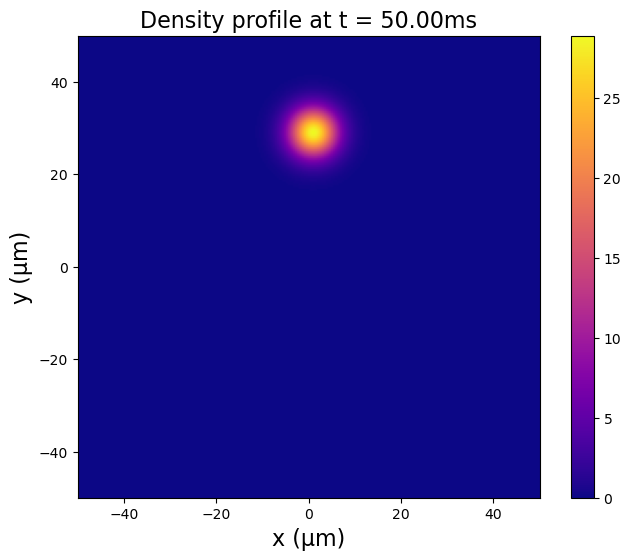


Continuing with original potential for 30 ms...
Evolution for 50 ms = 100 steps
Potential updated with center=(0, 0), beta=0, omega=0.0314 ms^-1
Evolution completed for 50 ms (100 steps). Total time: 100.00 ms

Saving figures ...


<Figure size 640x480 with 0 Axes>

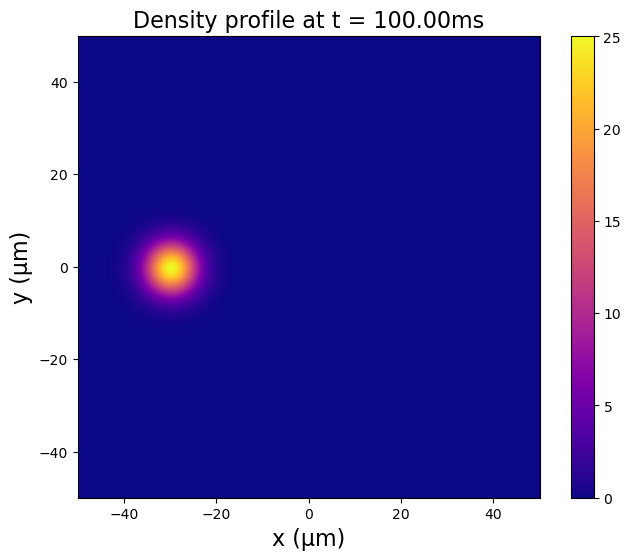


Continuing with original potential for 30 ms...
Evolution for 50 ms = 100 steps
Potential updated with center=(0, 0), beta=0, omega=0.0314 ms^-1
Evolution completed for 50 ms (100 steps). Total time: 150.00 ms

Saving figures ...


<Figure size 640x480 with 0 Axes>

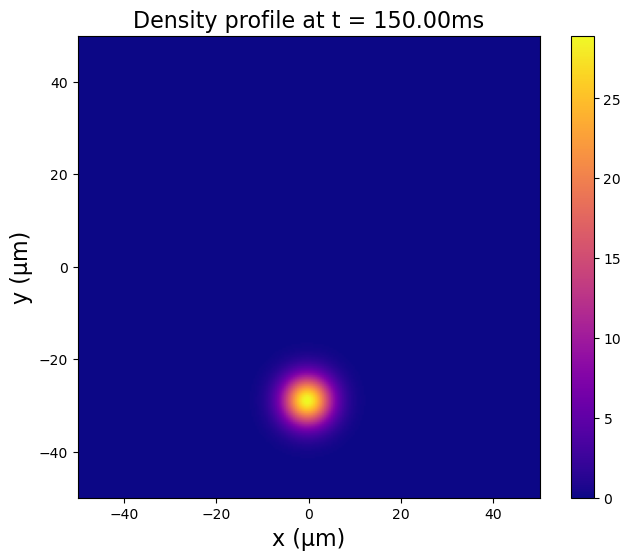


Continuing with original potential for 30 ms...
Evolution for 50 ms = 100 steps
Potential updated with center=(0, 0), beta=0, omega=0.0314 ms^-1
Evolution completed for 50 ms (100 steps). Total time: 200.00 ms

Saving figures ...


<Figure size 640x480 with 0 Axes>

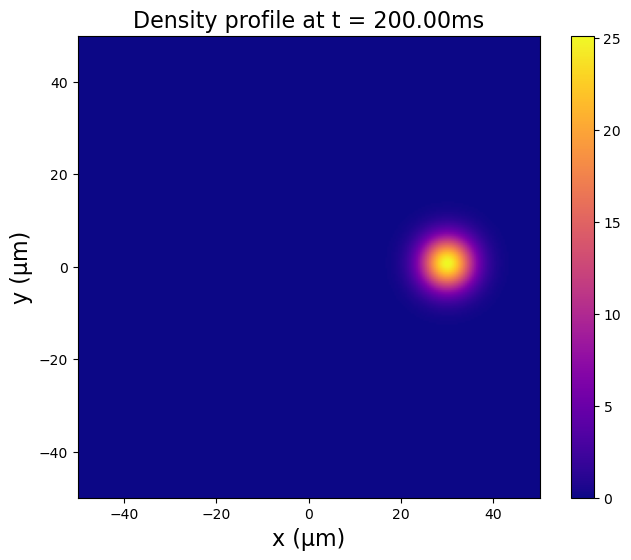


Simulation completed!


In [ ]:
# Example usage of the simulation

# Run initial evolution for 50 ms
print("Running initial evolution for 50 ms...")
evolve(50, new_trap_omega=0.01*cp.pi, new_beta=0)

# Continue with original potential for 20 ms
print("\nContinuing with original potential for 50 ms...")
evolve(50)

# Continue with original potential for 20 ms
print("\nContinuing with original potential for 50 ms...")
evolve(50)

# Continue with original potential for 20 ms
print("\nContinuing with original potential for 50 ms...")
evolve(50)

# # Continue with original potential for 20 ms
# print("\nContinuing with original potential for 20 ms...")
# evolve(20)

# # Change potential and continue evolution for 30 ms
# print("\nChanging potential and continuing evolution for 30 ms...")
# evolve(30, new_trap_center=(10, 10), new_beta=-0.05, new_trap_omega=0.02*np.pi)

print("\nSimulation completed!")